In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

import scipy.stats

In [3]:
plt.style.use('notebook')

In [4]:
t = Table.read('../data/rcat.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


27962


In [5]:
blue = '#0039d3'
purple = '#4700d3'
orange = '#ff6200'
pink = '#ee0449'

In [6]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [7]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.1,0.18]
p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.16,0.1]
p_lowa = [-0.14,0.15]
# p_lowa = [-0.2,0.1]
poly_lowa = np.poly1d(p_lowa)

ind_trap = ((t['init_FeH']>-0.5) & (t['init_FeH']<-0.1) & (t['init_aFe']>0.0) 
            & (t['init_aFe']<poly_lowa(t['init_FeH'])))
ind_lowa = ind_trap & ind_lowe
ind_lowa = ind_lowe & (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH'])) & (t['init_FeH']<-0.1)
ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe
ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & ind_lowe

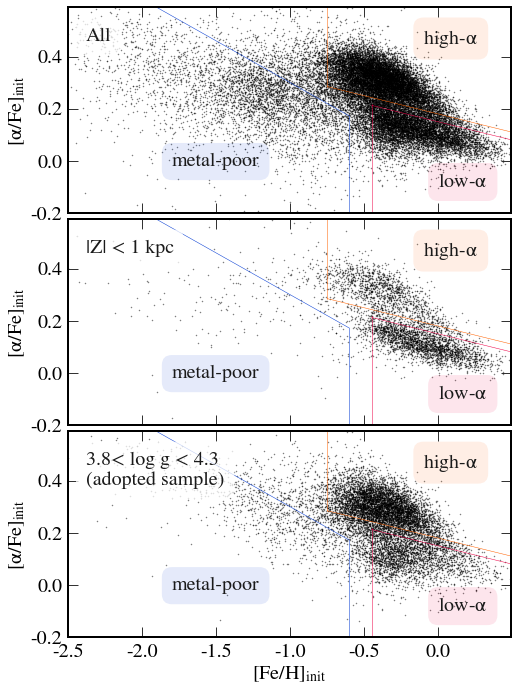

In [45]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)

afeh_panels = ['All', '|Z| < 1 kpc', '{:.1f}< log g < {:.1f}\n(adopted sample)'.format(loggmin, loggmax)]

fig, ax = plt.subplots(3,1,figsize=(7.5,10), sharex=True, sharey=True)

for e, ind in enumerate([ind_all, ind_z, ind_safeage]):
    plt.sca(ax[e])
    plt.plot(t['init_FeH'][ind], t['init_aFe'][ind], 'ko', mew=0, ms=1.5, alpha=0.5, rasterized=True)

    plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=0.5)
    plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=0.5)
    plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=0.5)
    plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=0.5)
    plt.plot(x_lowa, y_lowa, '-', color=pink, label='', lw=0.5)
    plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.5)], '-', color=pink, label='', lw=0.5)
    
    plt.text(-0.1, 0.45, 'high-$\\alpha$', color='0.1',
         bbox=dict(facecolor=orange, ec='none', alpha=0.1, boxstyle='round', pad=0.5))
    plt.text(0, -0.1, 'low-$\\alpha$', color='0.1',
         bbox=dict(facecolor=pink, ec='none', alpha=0.1, boxstyle='round', pad=0.5))
    plt.text(-1.8, -0.02, 'metal-poor', color='0.1',
             bbox=dict(facecolor=blue, ec='none', alpha=0.1, boxstyle='round', pad=0.5))

    plt.text(0.04, 0.9, afeh_panels[e], color='0.1', transform=plt.gca().transAxes, va='top',
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.5))
    plt.ylabel('[$\\alpha$/Fe]$_{init}$')

plt.xlim(-2.5,0.49)
plt.ylim(-0.2, 0.59)
plt.xlabel('[Fe/H]$_{init}$')
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/afeh_selections.pdf')

In [9]:
rcyl = np.sqrt(t['X_gal']**2 + t['Y_gal']**2)

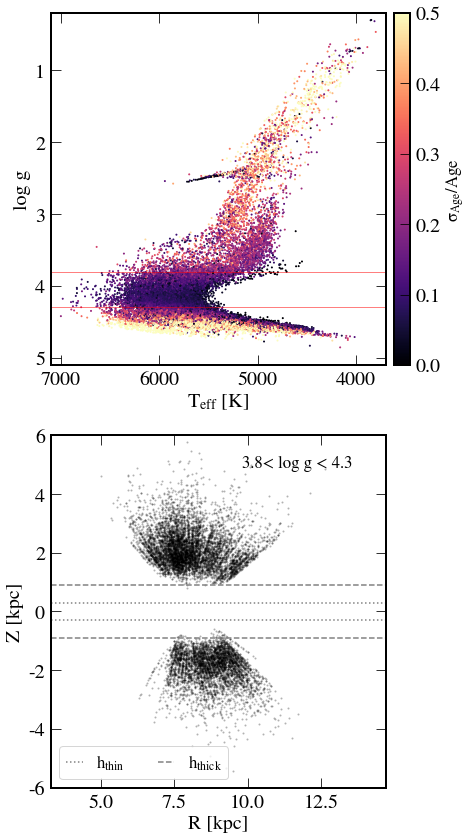

In [10]:
fig, ax = plt.subplots(2,1,figsize=(6,14.25), gridspec_kw=dict(hspace=0.2))

plt.sca(ax[0])
im = plt.scatter(t['Teff'], t['logg'], c=age_err/age, vmin=0, vmax=0.5, s=1, cmap='magma', rasterized=True)
plt.axhline(loggmin, ls='-', color='r', alpha=0.5, lw=1)
plt.axhline(loggmax, ls='-', color='r', alpha=0.5, lw=1)

plt.xlim(7100,3700)
plt.ylim(5.1,0.2)
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('log g')

pos = plt.gca().get_position()
cax = plt.axes([pos.x1+0.02,pos.y0,0.035,pos.y1 - pos.y0])
plt.colorbar(im, cax=cax) #, ticks=[-5,-2.5,0,2.5,5])
# plt.yticks(fontsize=font_tick)
plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

plt.sca(ax[1])
plt.plot(rcyl[ind_safeage], t['Z_gal'][ind_safeage], 'ko', mew=0, ms=2, alpha=0.3, label='', rasterized=True)

ls = [':', '--']
labels = ['$h_{thin}$', '$h_{thick}$']
for e, h in enumerate([0.3, 0.9]):
    plt.axhline(h, color='0.5', ls=ls[e], label=labels[e])
    plt.axhline(-h, color='0.5', ls=ls[e], label='')

plt.text(0.9,0.91,'{:.1f}< log g < {:.1f}'.format(loggmin, loggmax), fontsize='small', transform=plt.gca().transAxes,
        ha='right')
plt.legend(loc=3, fontsize='small', handlelength=1, ncol=2)
plt.ylim(-6,6)
plt.xlim(5,13)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')

# plt.tight_layout()
plt.savefig('../paper/sample.pdf')

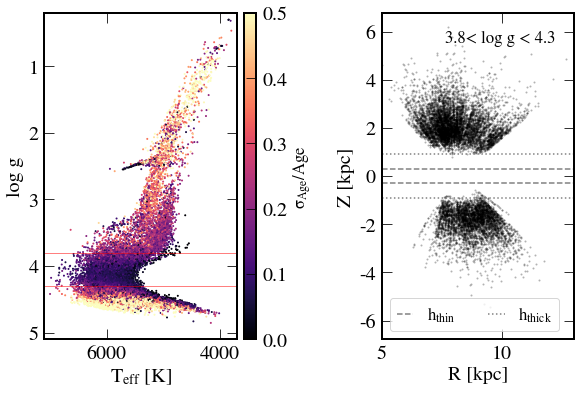

In [11]:
fig, ax = plt.subplots(1,2,figsize=(9.5,6), gridspec_kw=dict(wspace=0.75))

plt.sca(ax[0])
im = plt.scatter(t['Teff'], t['logg'], c=age_err/age, vmin=0, vmax=0.5, s=1, cmap='magma')
plt.axhline(loggmin, ls='-', color='r', alpha=0.5, lw=1)
plt.axhline(loggmax, ls='-', color='r', alpha=0.5, lw=1)

plt.xlim(7100,3700)
plt.ylim(5.1,0.2)
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('log g')

pos = plt.gca().get_position()
cax = plt.axes([pos.x1+0.01,pos.y0,0.018,pos.y1 - pos.y0])
plt.colorbar(im, cax=cax) #, ticks=[-5,-2.5,0,2.5,5])
# plt.yticks(fontsize=font_tick)
plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

plt.sca(ax[1])
plt.plot(rcyl[ind_safeage], t['Z_gal'][ind_safeage], 'ko', mew=0, ms=2, alpha=0.3, label='')

ls = ['--', ':']
labels = ['$h_{thin}$', '$h_{thick}$']
for e, h in enumerate([0.3, 0.9]):
    plt.axhline(h, color='0.5', ls=ls[e], label=labels[e])
    plt.axhline(-h, color='0.5', ls=ls[e], label='')

plt.text(0.9,0.91,'{:.1f}< log g < {:.1f}'.format(loggmin, loggmax), fontsize='small', transform=plt.gca().transAxes,
        ha='right')
plt.legend(loc=3, fontsize='small', handlelength=1, ncol=2)
plt.ylim(-6,6)
plt.xlim(5,13)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')

# plt.tight_layout()
plt.savefig('../paper/sample.png')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


[0.09986697 0.16064113]


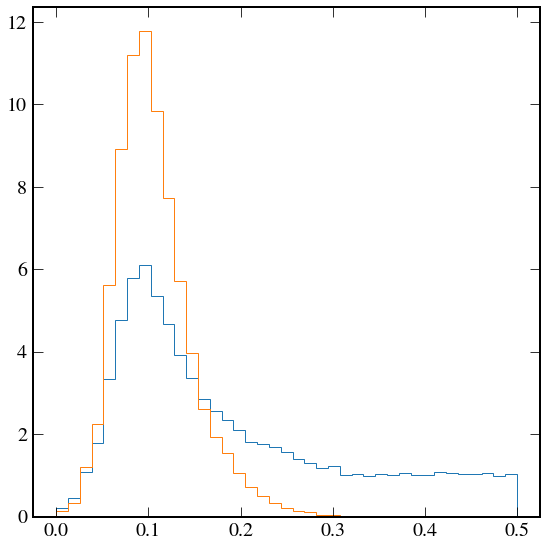

In [37]:
pbins = np.linspace(0,0.5,40)
rel_age = age_err/age
plt.hist(rel_age, bins=pbins, normed=True, histtype='step')
plt.hist(rel_age[ind_safeage], bins=pbins, normed=True, histtype='step')

print(np.percentile(rel_age[ind_safeage], [50,90]))

plt.tight_layout()

In [46]:
np.median(age[ind_safeage & ind_mpoor])

11.77008940508168

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


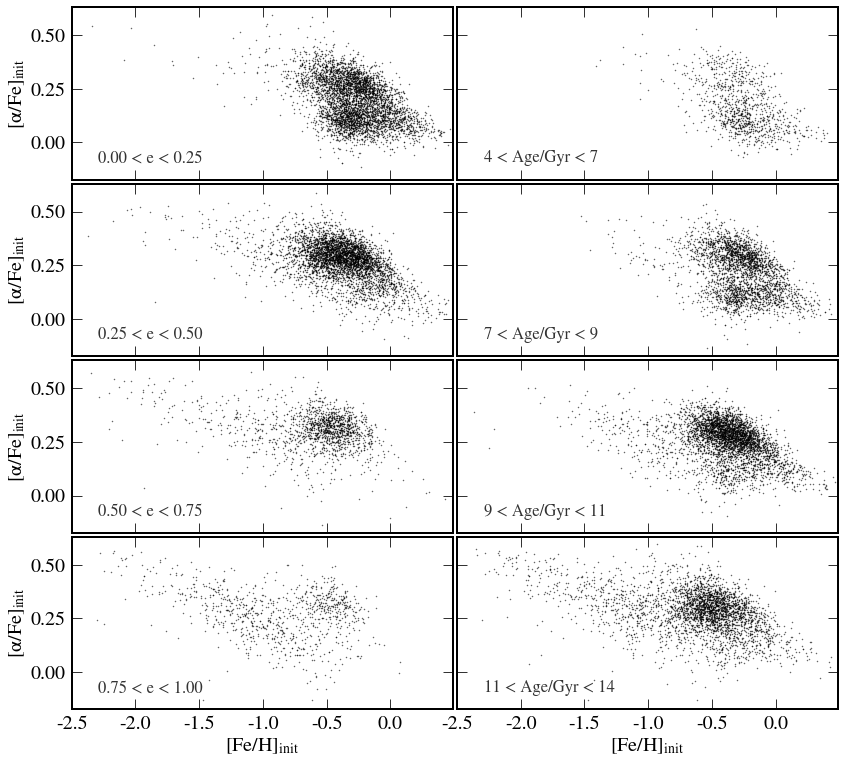

In [51]:
ecc_ranges = np.array([0,0.25,0.5,0.75,1])
age_ranges = np.array([4,7,9,11,14])
Ne = np.size(ecc_ranges) - 1

da = 6
fig, ax = plt.subplots(Ne,2,figsize=(12,11), sharey=True, sharex=True)

for i in range(Ne):
    ind = (t['eccen_pot1']>=ecc_ranges[i]) & (t['eccen_pot1']<ecc_ranges[i+1])
    
    plt.sca(ax[i][0])
    plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
            label='', rasterized=True)

    plt.xlim(-2.5,0.49)
    plt.ylabel('[$\\alpha$/Fe]$_{init}$')
    plt.text(0.07,0.1,'{:.2f} < e < {:.2f}'.format(ecc_ranges[i], ecc_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
    # right column
    plt.sca(ax[i][1])
    ind = (age>=age_ranges[i]) & (age<age_ranges[i+1])
    plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
            label='', rasterized=True)
    plt.text(0.07,0.1,'{:.0f} < Age/Gyr < {:.0f}'.format(age_ranges[i], age_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
for j in range(2):
    plt.sca(ax[Ne-1][j])
    plt.xlabel('[Fe/H]$_{init}$')

plt.tight_layout(w_pad=0.2, h_pad=0.2)
plt.savefig('../paper/afeh_eccen_age.pdf')

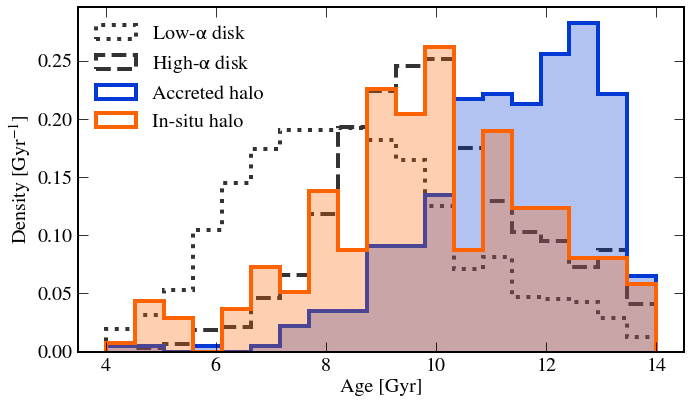

In [13]:
abins = np.linspace(4,14,20)

plt.figure(figsize=(10,6))

plt.hist(age[ind_safeage & ind_lowa], color='0.2', bins=abins, alpha=1, density=True,
         label='Low-$\\alpha$ disk', histtype='step', ls=':', lw=4)
plt.hist(age[ind_safeage & ind_thick], color='0.2', bins=abins, alpha=1, density=True,
         label='High-$\\alpha$ disk', histtype='step', ls='--', lw=4)
# plt.hist(age[ind_safeage & ind_lowa], color=pink, bins=abins, alpha=0.3, density=True, label='')
# plt.hist(age[ind_safeage & ind_lowa], color=pink, bins=abins, alpha=1, density=True,
#          label='Low-$\\alpha$ disk', histtype='step', ls='-', lw=4)
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, density=True, histtype='step', lw=4,
         label='Accreted halo')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, density=True, histtype='step', lw=4,
         label='In-situ halo')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../paper/ages.png')

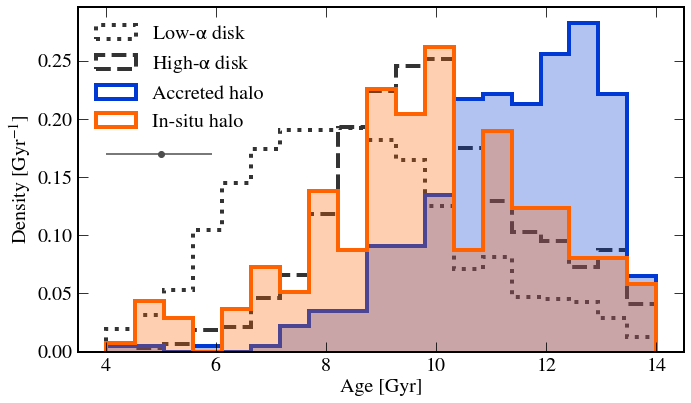

In [50]:
abins = np.linspace(4,14,20)

# bins_coarse = np.linspace(4,14,5)
# bins_cen = 0.5 * (bins_coarse[1:] + bins_coarse[:-1])
# med_err, _, _ = scipy.stats.binned_statistic(age[ind_safeage], age_err[ind_safeage], bins=bins_coarse,
#                                              statistic='median')
# nbin = np.size(bins_cen)

plt.figure(figsize=(10,6))

plt.hist(age[ind_safeage & ind_lowa], color='0.2', bins=abins, alpha=1, density=True,
         label='Low-$\\alpha$ disk', histtype='step', ls=':', lw=4)
plt.hist(age[ind_safeage & ind_thick], color='0.2', bins=abins, alpha=1, density=True,
         label='High-$\\alpha$ disk', histtype='step', ls='--', lw=4)
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, density=True, histtype='step', lw=4,
         label='Accreted halo')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, density=True, histtype='step', lw=4,
         label='In-situ halo')

plt.errorbar(np.array([5]), np.array([0.17]), yerr=None,
             xerr=np.array([np.median(age_lerr[ind_safeage]), np.median(age_uerr[ind_safeage])])[:,np.newaxis],
             fmt='o', color='0.3', capsize=0)
# plt.errorbar(bins_cen, np.ones(nbin)*-0.01, fmt='none', yerr=None, xerr=med_err, color='0.3')

plt.legend(loc=2, frameon=False )
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')
# plt.ylim(-0.02, 0.299)

plt.tight_layout()
plt.savefig('../paper/ages.pdf')

In [15]:
def f_ramp(x, x1, x2):
    if x2<x1:
        x_ = x2
        x2 = x1
        x1 = x_
    dx = x2-x1
    k = -2 * dx**-2
    l = 2/dx * (1 + x1/dx)
    
    fx = k*x + l
    ind = (x>=x1) & (x<=x2)
    fx[~ind] = 0

    return fx

def pdf_ramp(u, x1, x2):
    if x2<x1:
        x_ = x2
        x2 = x1
        x1 = x_
    dx = x2-x1
    k = -2 * dx**-2
    l = 2/dx * (1 + x1/dx)
    
    x = -np.sqrt((x1 + l/k)**2 + 2*u/k) - l/k
    
    return x

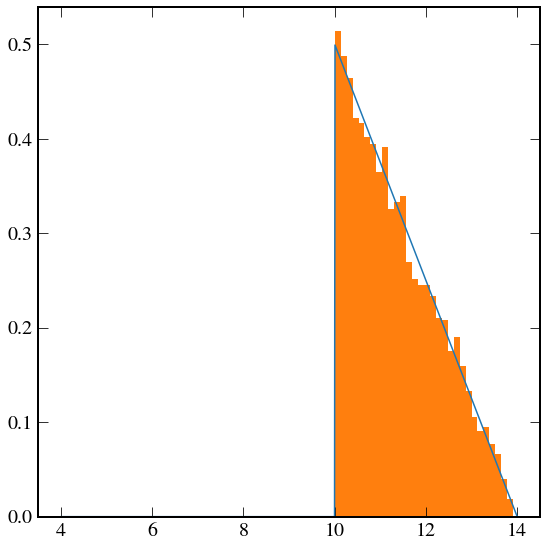

In [16]:
x_ = np.linspace(4,14,1000)
y_ = f_ramp(x_, 10, 14)
plt.plot(x_, y_, '-')

u = np.random.random(5000)
x = pdf_ramp(u, 10, 14)
plt.hist(x, bins=30, density=True)

plt.tight_layout()

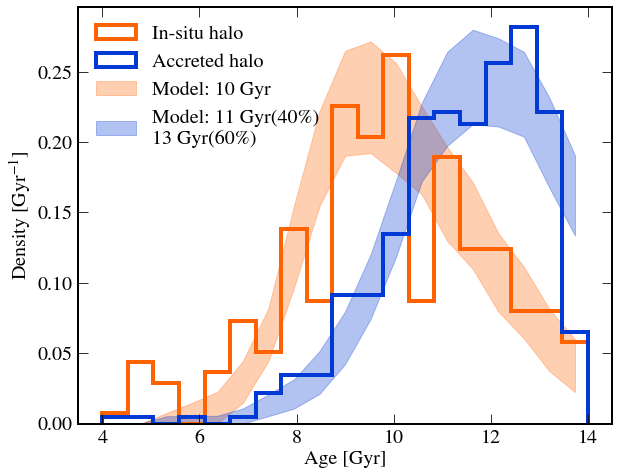

In [48]:
nacc = np.sum(ind_safeage & ind_ge)
obs_acc = age[ind_safeage & ind_ge]
err_acc = age_err[ind_safeage & ind_ge]

nins = np.sum(ind_safeage & ind_splash)
obs_ins = age[ind_safeage & ind_splash]
err_ins = age_err[ind_safeage & ind_splash]

np.random.seed(4629)

nboot = 200
nbin = np.size(abins) - 1
bcen = 0.5 * (abins[1:] + abins[:-1])
h_age_acc = np.empty((nboot, nbin))
h_age_ins = np.empty((nboot, nbin))

f = 0.4
n1 = int(nacc*f)
n2 = nacc - n1

for i in range(nboot):
    # sample accreted halo from a flat distribution
    model_acc = np.random.rand(nacc)*3.7 + 10.3
#     model_acc = np.concatenate([np.ones(n1)*11, np.ones(n2)*13])
#     model_acc_conv = np.random.randn(nacc)*np.random.permutation(err_acc) + np.random.permutation(model_acc)
    log_model_acc = np.log10(model_acc)
    log_model_acc_conv = (np.random.randn(nacc)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_ge])
                          + np.random.permutation(log_model_acc))
    model_acc_conv = 10**log_model_acc_conv
    h, be = np.histogram(model_acc_conv, bins=abins, density=True)
    h_age_acc[i] = h
    
    # sample in-situ halo from a narrow gaussian
#     model_ins = np.random.randn(nins)*1.5 + 10
#     model_ins = np.ones(nins)*10
    model_u = np.random.rand(nins)
    model_ins = pdf_ramp(model_u, 8.3, 14)
#     model_ins_conv = np.random.randn(nins)*np.random.permutation(err_ins) + np.random.permutation(model_ins)
    log_model_ins = np.log10(model_ins)
    log_model_ins_conv = (np.random.randn(nins)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_splash])
                          + np.random.permutation(log_model_ins))
    model_ins_conv = 10**log_model_ins_conv
    h, be = np.histogram(model_ins_conv, bins=abins, density=True)
    h_age_ins[i] = h

model_acc_dn, model_acc_up = np.percentile(h_age_acc, [16,84], axis=0)
model_ins_dn, model_ins_up = np.percentile(h_age_ins, [16,84], axis=0)

plt.figure(figsize=(9,7))

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=4, density=True, label='In-situ halo')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='Model: 10 Gyr')

plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=4, density=True, label='Accreted halo')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Model: 11 Gyr(40%)\n13 Gyr(60%)')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../plots/ages_model_delta.png')

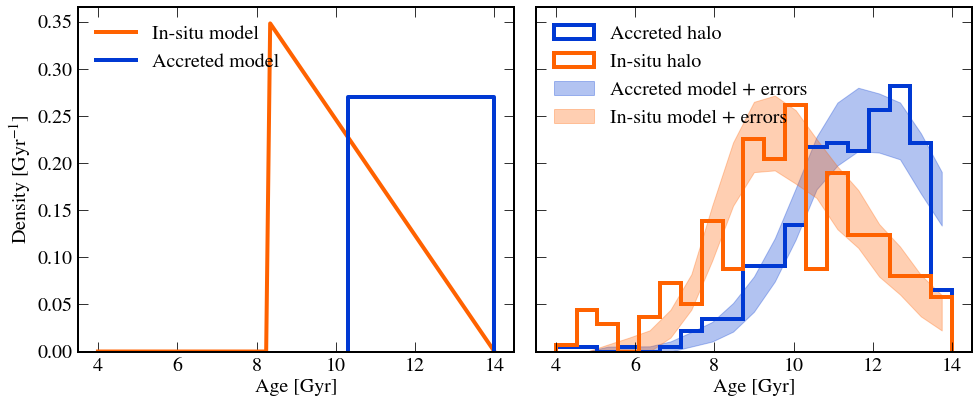

In [49]:
fig, ax = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)

plt.sca(ax[0])
x_ = np.linspace(4,14,100)
# y_ = scipy.stats.norm.pdf(x_, 10, 1.5)
y_ = f_ramp(x_, 8.3, 14)
plt.plot(x_, y_, '-', color=orange, lw=4, label='In-situ model')

y = 1/3.7
x_ = np.array([10.3, 10.3, 14, 14])
y_ = np.array([0, y, y, 0])
plt.plot(x_, y_, '-', color=blue, lw=4, label='Accreted model')

# ymax = np.max(y_)/0.6
# x_ = np.array([11,11])
# y_ = np.array([0, 0.4*ymax])
# plt.plot(x_, y_, '-', color=blue, lw=4, label='Accreted model')

# x_ = np.array([13,13])
# y_ = np.array([0, 0.6*ymax])
# plt.plot(x_, y_, '-', color=blue, lw=4, label='')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.sca(ax[1])
plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=4, density=True, label='Accreted halo')
# plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Model: const(10.3, 13.1)')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Accreted model + errors')

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=4, density=True, label='In-situ halo')
# plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='Model: normal(10, 1.5)')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='In-situ model + errors')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
# plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../paper/ages_model.pdf')

- among old disk stars on high eccentricity -- possible to measure fraction of low-alpha compared (perhaps both disks affected, but alpha-poor not that poor at the time?)
- Shy Genel: maybe quenched passing through a filament? can we find an orbit in this larger-scale context

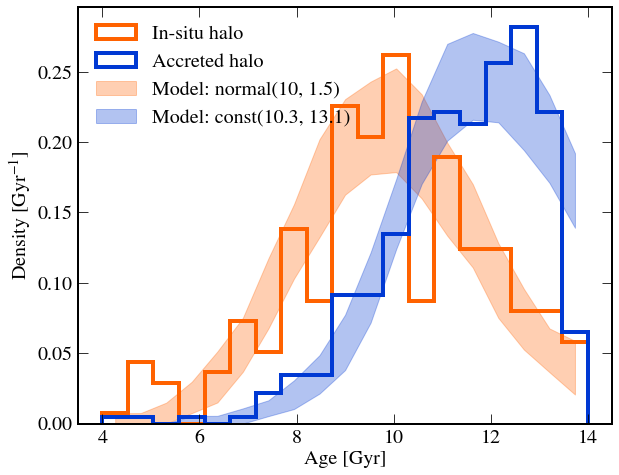

In [224]:
nacc = np.sum(ind_safeage & ind_ge)
obs_acc = age[ind_safeage & ind_ge]
err_acc = age_err[ind_safeage & ind_ge]

nins = np.sum(ind_safeage & ind_splash)
obs_ins = age[ind_safeage & ind_splash]
err_ins = age_err[ind_safeage & ind_splash]

np.random.seed(4629)

nboot = 200
nbin = np.size(abins) - 1
bcen = 0.5 * (abins[1:] + abins[:-1])
h_age_acc = np.empty((nboot, nbin))
h_age_ins = np.empty((nboot, nbin))

for i in range(nboot):
    # sample accreted halo from a flat distribution
    model_acc = np.random.rand(nacc)*3.7 + 10.3
#     model_acc = np.ones(nacc)*11
#     model_acc_conv = np.random.randn(nacc)*np.random.permutation(err_acc) + np.random.permutation(model_acc)
    log_model_acc = np.log10(model_acc)
    log_model_acc_conv = (np.random.randn(nacc)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_ge])
                          + np.random.permutation(log_model_acc))
    model_acc_conv = 10**log_model_acc_conv
    h, be = np.histogram(model_acc_conv, bins=abins, density=True)
    h_age_acc[i] = h
    
    # sample in-situ halo from a narrow gaussian
    model_ins = np.random.randn(nins)*1.5 + 10
#     model_ins = np.ones(nins)*9.7
#     model_ins_conv = np.random.randn(nins)*np.random.permutation(err_ins) + np.random.permutation(model_ins)
    log_model_ins = np.log10(model_ins)
    log_model_ins_conv = (np.random.randn(nins)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_splash])
                          + np.random.permutation(log_model_ins))
    model_ins_conv = 10**log_model_ins_conv
    h, be = np.histogram(model_ins_conv, bins=abins, density=True)
    h_age_ins[i] = h

model_acc_dn, model_acc_up = np.percentile(h_age_acc, [16,84], axis=0)
model_ins_dn, model_ins_up = np.percentile(h_age_ins, [16,84], axis=0)

plt.figure(figsize=(9,7))

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=4, density=True, label='In-situ halo')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='Model: normal(10, 1.5)')

plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=4, density=True, label='Accreted halo')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Model: const(10.3, 13.1)')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../plots/ages_model_only.png')

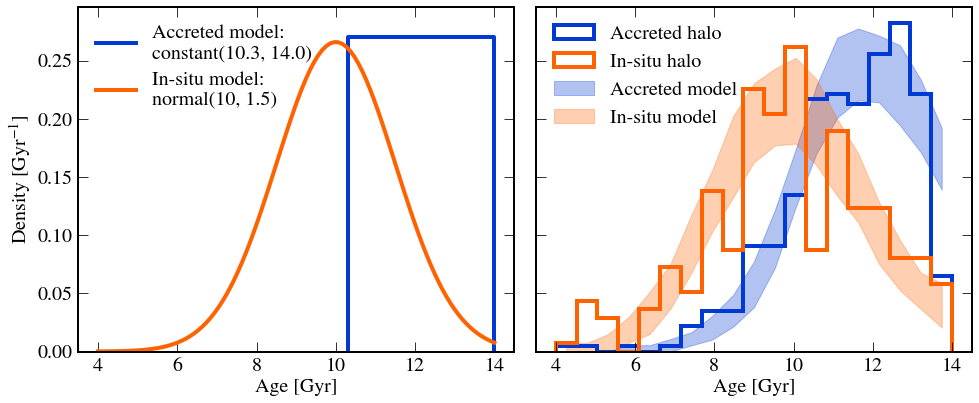

In [225]:
fig, ax = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)

plt.sca(ax[0])
y = 1/3.7
x_ = np.array([10.3, 10.3, 14, 14])
y_ = np.array([0, y, y, 0])
plt.plot(x_, y_, '-', color=blue, lw=4, label='Accreted model:\nconstant(10.3, 14.0)')

x_ = np.linspace(4,14,100)
y_ = scipy.stats.norm.pdf(x_, 10, 1.5)
plt.plot(x_, y_, '-', color=orange, lw=4, label='In-situ model:\nnormal(10, 1.5)')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.sca(ax[1])
plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=4, density=True, label='Accreted halo')
# plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Model: const(10.3, 13.1)')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Accreted model')

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=4, density=True, label='In-situ halo')
# plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='Model: normal(10, 1.5)')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='In-situ model')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
# plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../plots/ages_model.png')